# Notebook for an example Coronal Model Evaluation full cycle

In [177]:
from CHmetric import CHmetric, ezseg
from WLmetric import WLmetric, io_functions as io_WL
from NLmetric import NLmetric

from CHMAP import chmap

import helpers as h

import datetime
import matplotlib.pyplot as plt
import pfsspy
import numpy as np
import sunpy.map

## Coronal Hole Metric

### Step 1 : Create Carrington Map using EUV data from +/- 14 days surrounding an input date

In [2]:
euvmappath = CHmetric.create_euv_map(datetime.datetime(2018,11,6),replace=False)

In [3]:
euvmap = sunpy.map.Map(euvmappath)

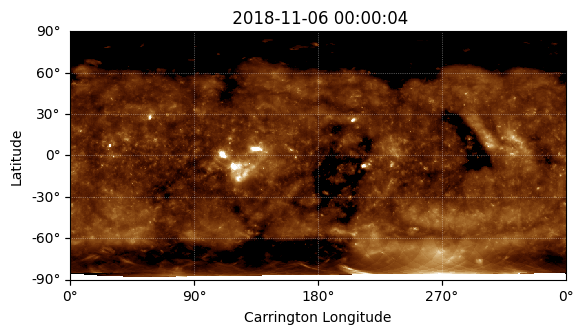

In [4]:
euvmap.plot(cmap="sdoaia193",
            vmin=np.nanpercentile(euvmap.data.flatten(),20),
            vmax=np.nanpercentile(euvmap.data.flatten(),99.9)
            
           )

### Step 2 : Extract Coronal Hole Contours with EZSEG

In [5]:
## Takes about a min to run in python
ch_obs_path = CHmetric.extract_obs_ch(euvmappath,
                                      replace=False,
                                      ezseg_params={
                                          "thresh1":1.5,#np.nanmax(euvmap.data.flatten())*0.07, ## Seed threshold
                                          "thresh2":1.75,#np.nanmax(euvmap.data.flatten())*0.101, ## Growing Threshhold
                                          "nc":5, ## at least 7 consecutive pixels to declare coronal hole area is connected
                                          "iters":100
                                      }
                                     )

ch_obs_map = sunpy.map.Map(ch_obs_path)

/home/sbadman/anaconda3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


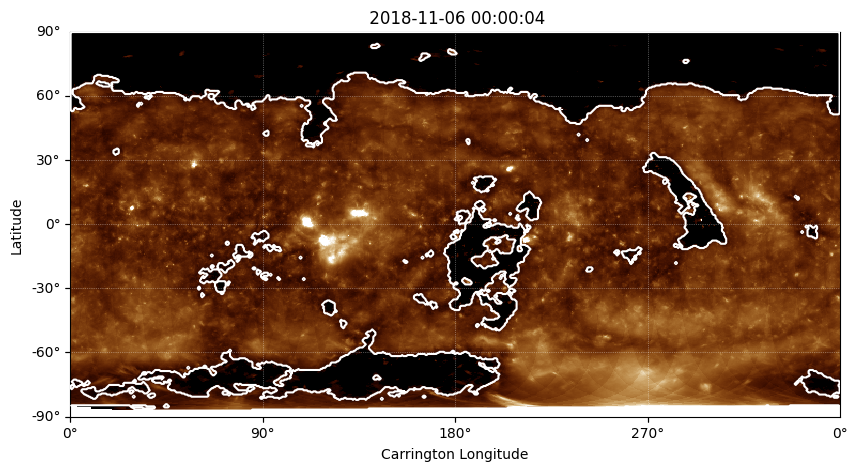

In [6]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection=euvmap.wcs)
euvmap.plot(cmap="sdoaia193",
            vmin=np.nanpercentile(euvmap.data.flatten(),20),
            vmax=np.nanpercentile(euvmap.data.flatten(),99.9),
            axes=ax
           )
ch_obs_map.draw_contours(levels=[1],colors=["white"],axes=ax)

### Step 3 : Load in Model Coronal Hole Map and Run Binary Classifier to Score

Text(0.5, 1.0, 'Overlap')

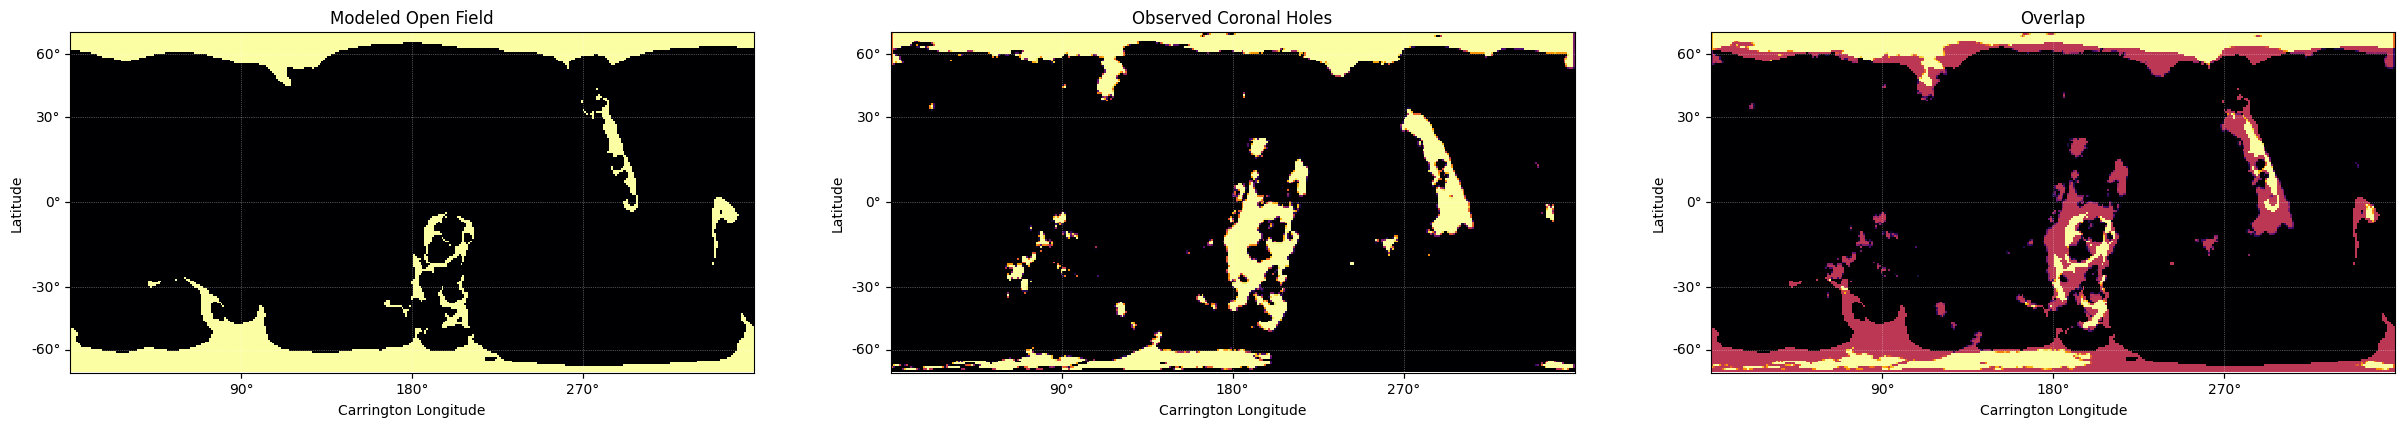

In [13]:
### We have some sample coronal hole and neutral line maps in the folder:
# ./example_model_data/
# Let's choose one
chmap_model_example_path = "./example_model_data/OpenFieldlineMap_Badman_AHMI_2018-11-06_2.5Rs.csv"

# Here's a function that can load these CSV files and port them into a sunpy.map
# as we've been working with above. We need to specify the model time, which we 
# can read from the filename.
datetime_model = datetime.datetime(2018,11,6)
chmap_model_example_map = CHmetric.csv2map(chmap_model_example_path,
                                           datetime_model
                                          )

### The model result y-axis is binned in the Cylindrical equal area projection
# while the observation is binned in latitude. We can convert one to the other
# by using the sunpy reprojection api (this also will interpolate the map to 
# the same resolution as the model result, which we also need for doing the
# pixel by pixel classification )
ch_obs_cea = ch_obs_map.reproject_to(chmap_model_example_map.wcs)
ch_combined = sunpy.map.Map(
    ch_obs_cea.data+chmap_model_example_map.data,
    chmap_model_example_map.meta
)
## Now we can plot this side by side with "observed" coronal holes and see
## how they compare
fig = plt.figure(figsize=(30,5))
axmodel = fig.add_subplot(131,projection=chmap_model_example_map.wcs) 
axobs = fig.add_subplot(132,projection=ch_obs_cea.wcs)
axcomb = fig.add_subplot(133,projection=chmap_model_example_map.wcs)
chmap_model_example_map.plot(cmap="inferno",axes=axmodel)
ch_obs_cea.plot(cmap="inferno",axes=axobs)
ch_combined.plot(cmap="inferno",axes=axcomb)
axmodel.set_title("Modeled Open Field")
axobs.set_title("Observed Coronal Holes")
axcomb.set_title("Overlap")

In [14]:
### Lastly, we use the binary classification method defined in Badman+2022 to score the agreement between the models
p,r,f = CHmetric.do_ch_score(datetime_model,
                             chmap_model_example_path,
                             ch_obs_path,
                             auto_interp=True)
print(f"Precision : {100*p:.1f}%, Recall : {100*r:.1f}%, F-Score : {100*f:.1f}%")

Precision : 58.8%, Recall : 60.9%, F-Score : 59.8%


## Streamer Belt Metric

### Step 1 - Create or Load a White Light Carrington Map

In [169]:
from importlib import reload; reload(WLmetric); reload(io_WL)

<module 'WLmetric.io_functions' from '/home/sbadman/1_RESEARCH/GIT_REPOS/CoronalModelEval/WLmetric/io_functions.py'>

In [227]:
#### Capability to create pending

#### Load Precomputed Ones

### Either download from online source (2020-2023) or download local 

## Load Local File (2018-2020)
WL_date = datetime.datetime(2018,11,6)
WL_path = "./WLmetric/data/"
WL_source = "V1.1"
[WL_fullpath,WL_date] = io_WL.get_WL_map(WL_date,WL_path,WL_source)

## Download from IRAP Connect Tool connect-tool.irap.omp.eu (2020-2023)
# WL_date = datetime.datetime(2021,10,10)
# WL_path = "./WLmetric/data/"
# WL_source = "connect_tool"
# [WL_fullpath,WL_date] = io_WL.get_WL_map(WL_date,WL_path,WL_source)

wlmap = io_WL.WLfile2map(WL_fullpath,WL_date,WL_source)

Local archive: the closest (in time) WL map available from input date: 2018-11-06T00:00:00 is: 2018-11-06 12:00:00


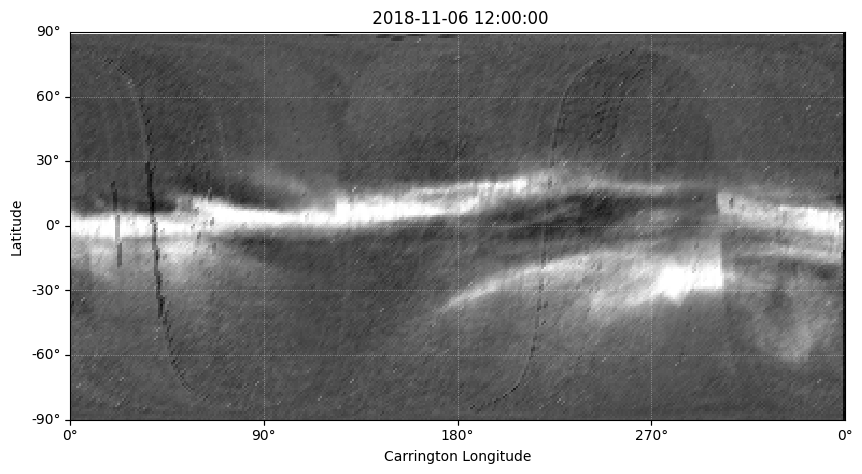

In [229]:
## Let's view what we just loaded in :
fig=plt.figure(figsize=(10,6))
wlmap.plot()

### Step 2 - Extract the Streamer Maximum Brightness Contour

In [230]:
### INPUT : sunpy.map.Map from a White Light Carrington Map
### OUTPUT : astropy.coordinates.SkyCoord describing the 
# location of maximum brightness in the image at each longitude
smb=WLmetric.extract_SMB(wlmap)

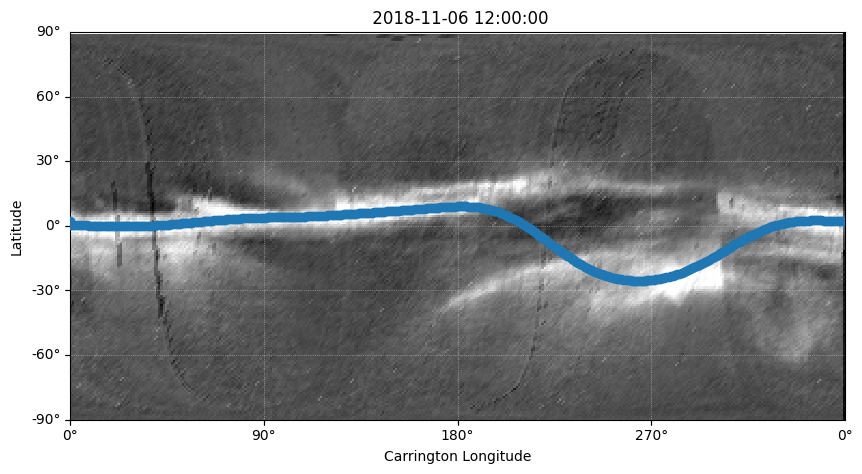

In [231]:
### View the extraction
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(projection=wlmap.wcs)
wlmap.plot(axes=ax)
ax.plot_coord(smb,"o")

### Step 3  - Obtain Equivalent Model Curve and Compute WL Metric Score

In [232]:
### We have some sample coronal hole and neutral line maps in the folder:
# ./example_model_data/
# Let's choose one
nlmap_model_example_path = "./example_model_data/NeutralLineMap_Badman_AHMI_2018-11-06_2.5Rs.csv"

# Here's a function that can load these CSV files and port them into a sunpy.map
# as we've been working with above. We need to specify the model time, which we 
# can read from the filename.
datetime_model = datetime.datetime(2018,11,6)
nlmap_model_example_map = h.csv2map(nlmap_model_example_path,
                                          datetime_model
                                          )

/home/sbadman/anaconda3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:254: UserWarning: The following kwargs were not used by contour: 'label'
  cset = super().contour(*args, **kwargs)


Text(0.5, 1.0, 'Comparison')

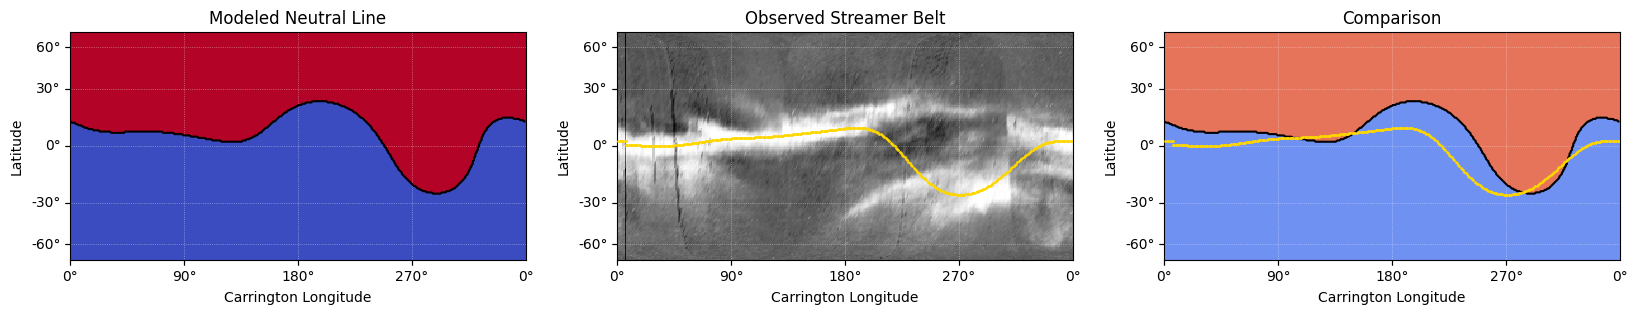

In [233]:
### The model result y-axis is binned in the Cylindrical equal area projection
# while the observation is binned in latitude. We can convert one to the other
# by using the sunpy reprojection api (this also will interpolate the map to 
# the same resolution as the model result, which we also need for doing the
# pixel by pixel classification )
wl_obs_cea = wlmap.reproject_to(nlmap_model_example_map.wcs)

## Now we can plot this side by side with "observed" coronal holes and see
## how they compare
fig = plt.figure(figsize=(20,5))
axmodel = fig.add_subplot(131,projection=nlmap_model_example_map.wcs) 
axobs = fig.add_subplot(132,projection=wl_obs_cea.wcs)
axcomp = fig.add_subplot(133,projection=nlmap_model_example_map.wcs)

nlmap_model_example_map.plot(cmap="coolwarm",axes=axmodel)
nlmap_model_example_map.draw_contours(levels=[0],colors=["black"],axes=axmodel)
wl_obs_cea.plot(cmap="Greys_r",axes=axobs)
axobs.plot_coord(smb,"o",color="gold",ms=1)
nlmap_model_example_map.plot(cmap="coolwarm",axes=axcomp,vmin=-1.5,vmax=1.5)
nlmap_model_example_map.draw_contours(levels=[0],colors=["black"],axes=axcomp,label="Model")
axcomp.plot_coord(smb,"o",color="gold",ms=1,label="Observed")

axmodel.set_title("Modeled Neutral Line")
axobs.set_title("Observed Streamer Belt")
axcomp.set_title("Comparison")

## Scratch

In [234]:
#plt.hist(np.log10(euvmap.data.flatten()),bins=100)

In [ ]:
# [WL_I, ## WL Intensity Map (reconstructed from RGB)
#  WL_pphi, ##Pixel center meshgrid coords (lon)
#  WL_tth, ## Pixel center meshgrid coords (lat)
#  WL_I_edges, ## Evaluate WL intensity at cell edges
#  WL_pphi_edges, ## Pixel edge meshgrid coords (lon)
#  WL_tth_edges ## Pixel edge meshgrid coords (lat)
# ] = io_WL.read_WL_map_connecttool(WL_fullpath)